In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


from scipy.stats import f_oneway
import numpy as np

# Carga del dataset

In [4]:
# load file
df = pd.read_csv('data/fact_application_v2_scaled.csv')

# Implementación del modelo

In [5]:
# apply dbscan
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=11).fit(df.drop(columns=['applicationcode']))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df['Cluster'] = labels

In [6]:
df['Cluster'].value_counts()

 0    529
-1     25
Name: Cluster, dtype: int64

c:\Users\fede_\anaconda3\envs\py310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


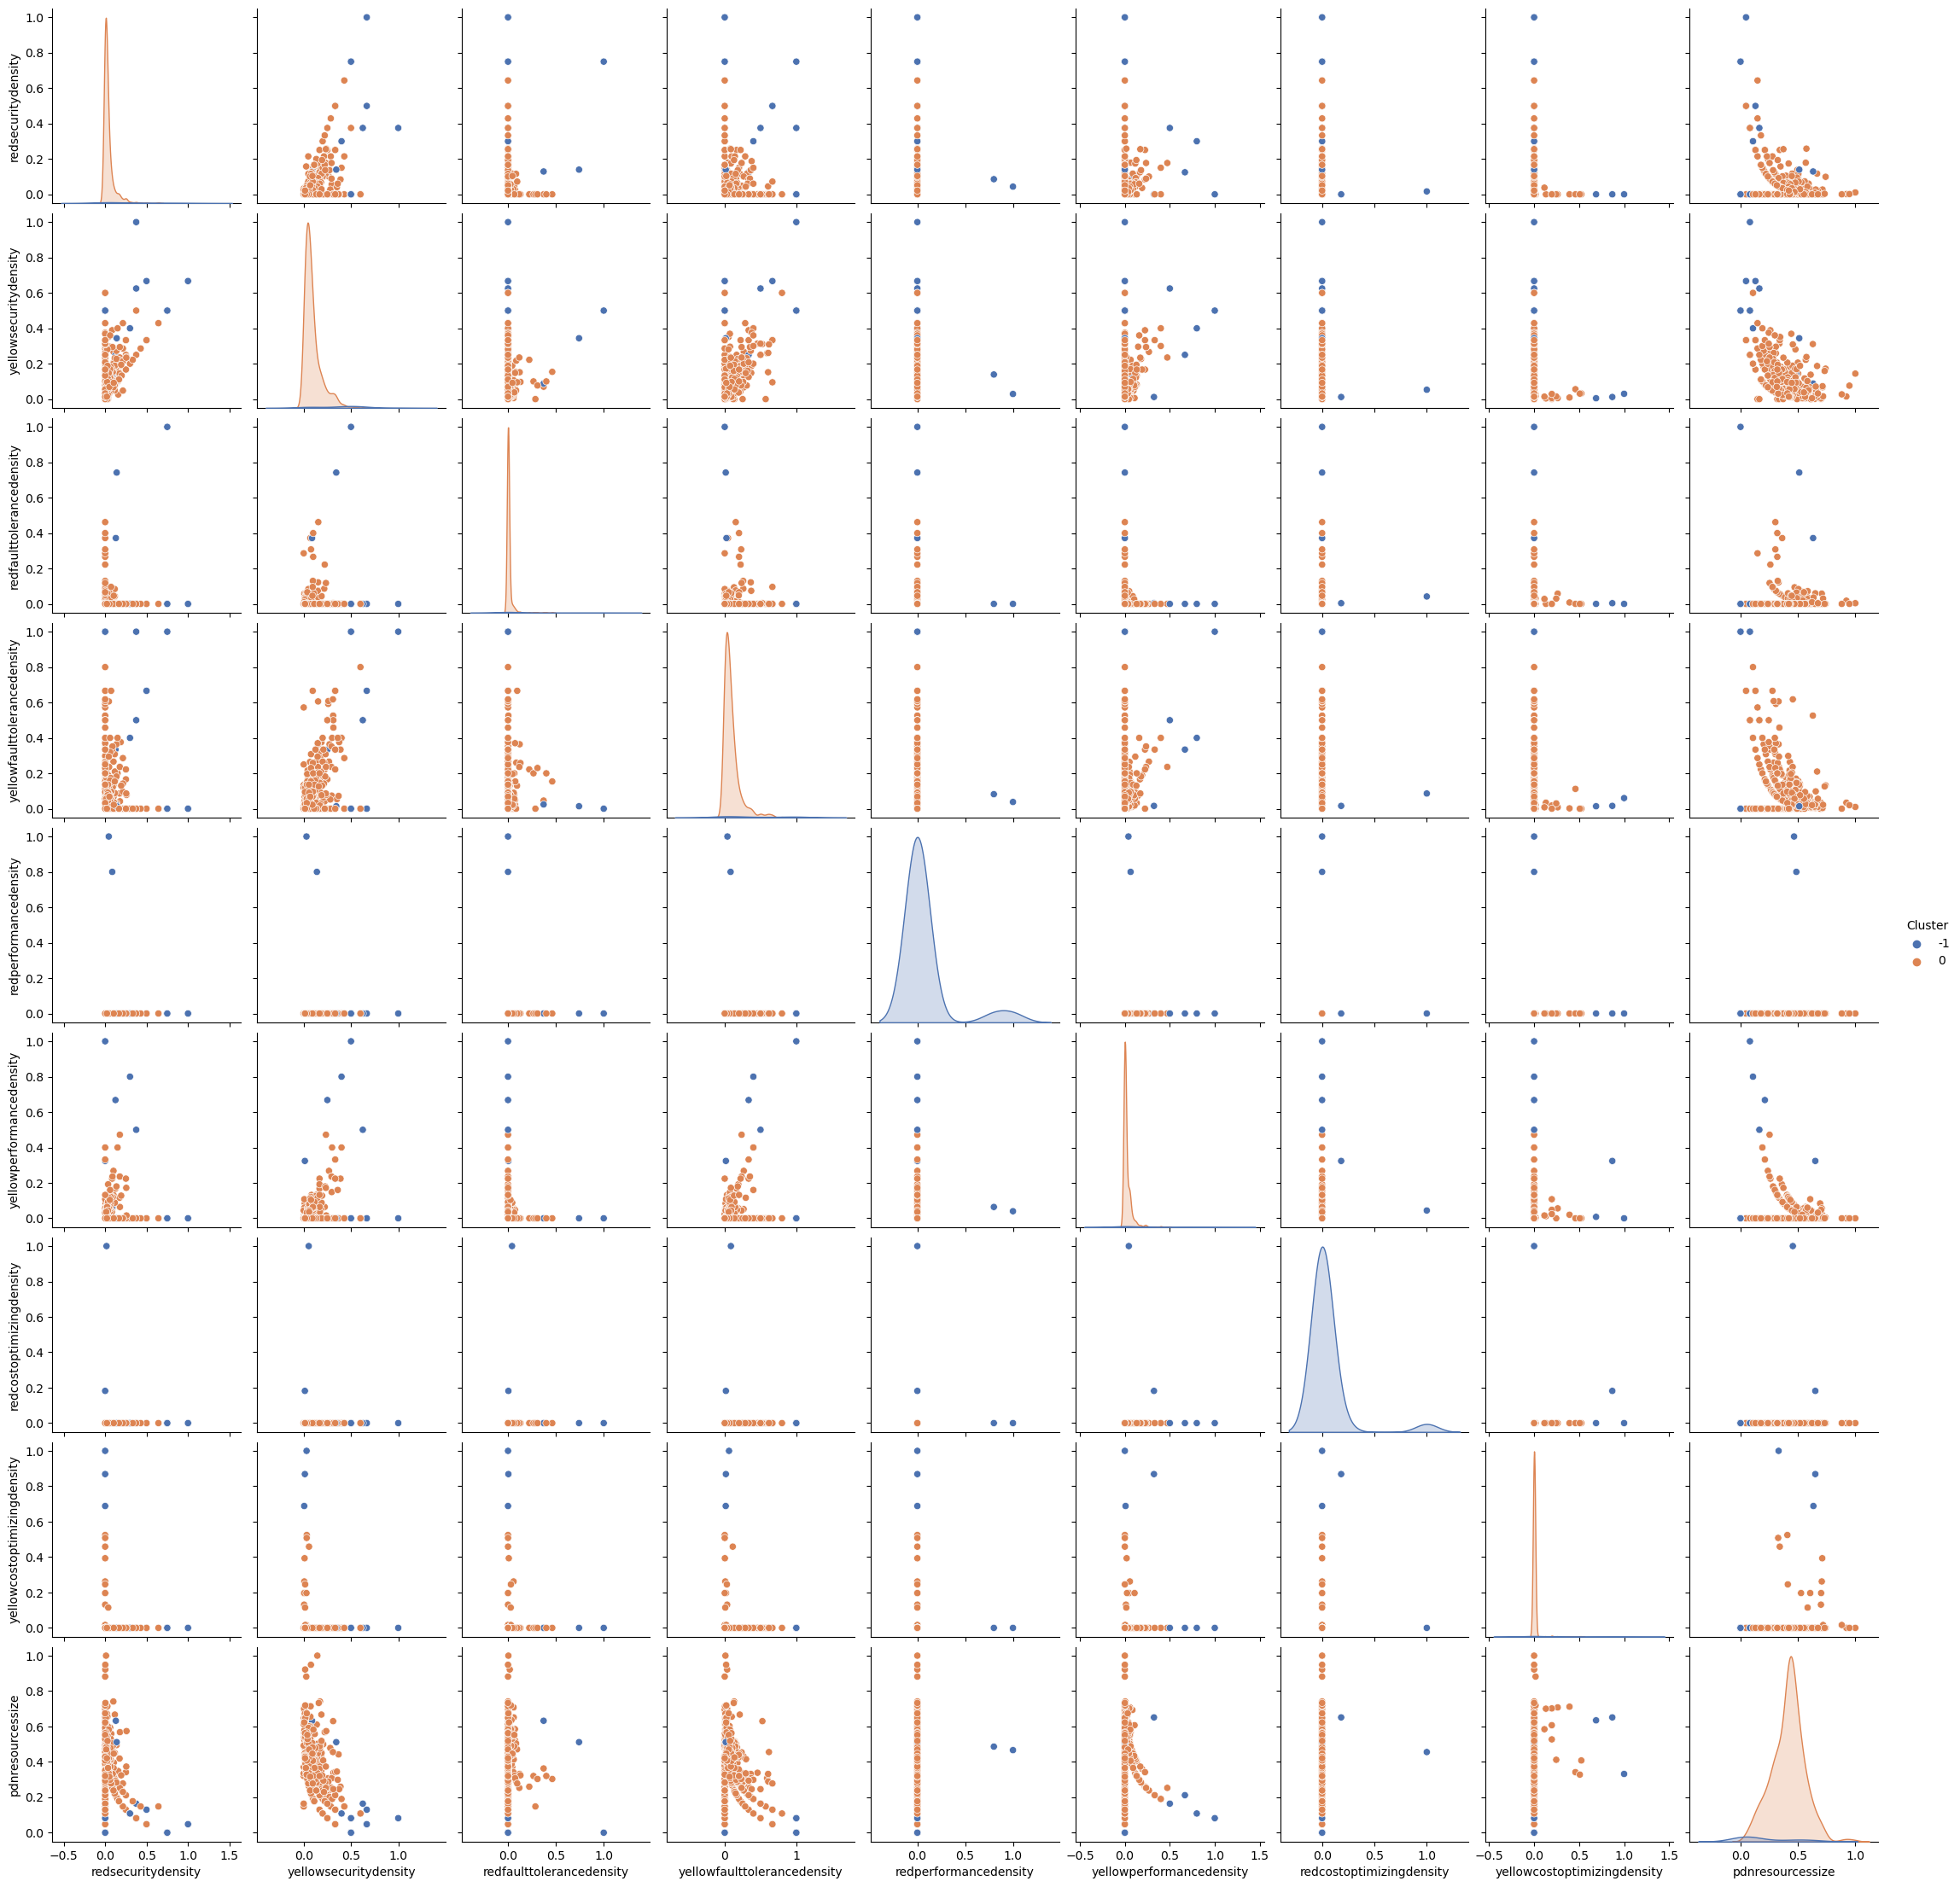

In [8]:
# pairplot
sns.pairplot(df, hue="Cluster", palette="deep")

In [9]:
# calculate the mean of every cluster
df.groupby('Cluster').mean().T

C:\Users\fede_\AppData\Local\Temp\ipykernel_3136\657990919.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Cluster').mean().T


Cluster,-1,0
redsecuritydensity,0.273403,0.037643
yellowsecuritydensity,0.392360,0.093478
redfaulttolerancedensity,0.086400,0.009486
yellowfaulttolerancedensity,0.436000,0.092079
redperformancedensity,0.072000,0.000000
yellowperformancedensity,0.137920,0.022110
redcostoptimizingdensity,0.047273,0.000000
yellowcostoptimizingdensity,0.102295,0.006167
pdnresourcessize,0.206952,0.413926
